# Base models

### BRIE base likelihood

$$\mathcal{L}(\psi; L_1, L_2, L_3, S_1, S_2, S_3)=\mathtt{Multinom}([S_1, S_2, S_3]; [p_1, p_2, p_3])$$

$$[p_1, p_2, p_3] = [\psi L_1, (1-\psi)L_2, L_3] / (\psi L_1 + (1-\psi)L_2 + L_3)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multinomial

def BRIE_base_lik(psi, counts, lengths):
    """Base likelihood function of BRIE model
    """
    size_vect = np.array([psi, (1 - psi), 1]) * lengths
    prob_vect = size_vect / np.sum(size_vect)
    
    rv = multinomial(np.sum(counts), prob_vect)
    return rv.pmf(counts)

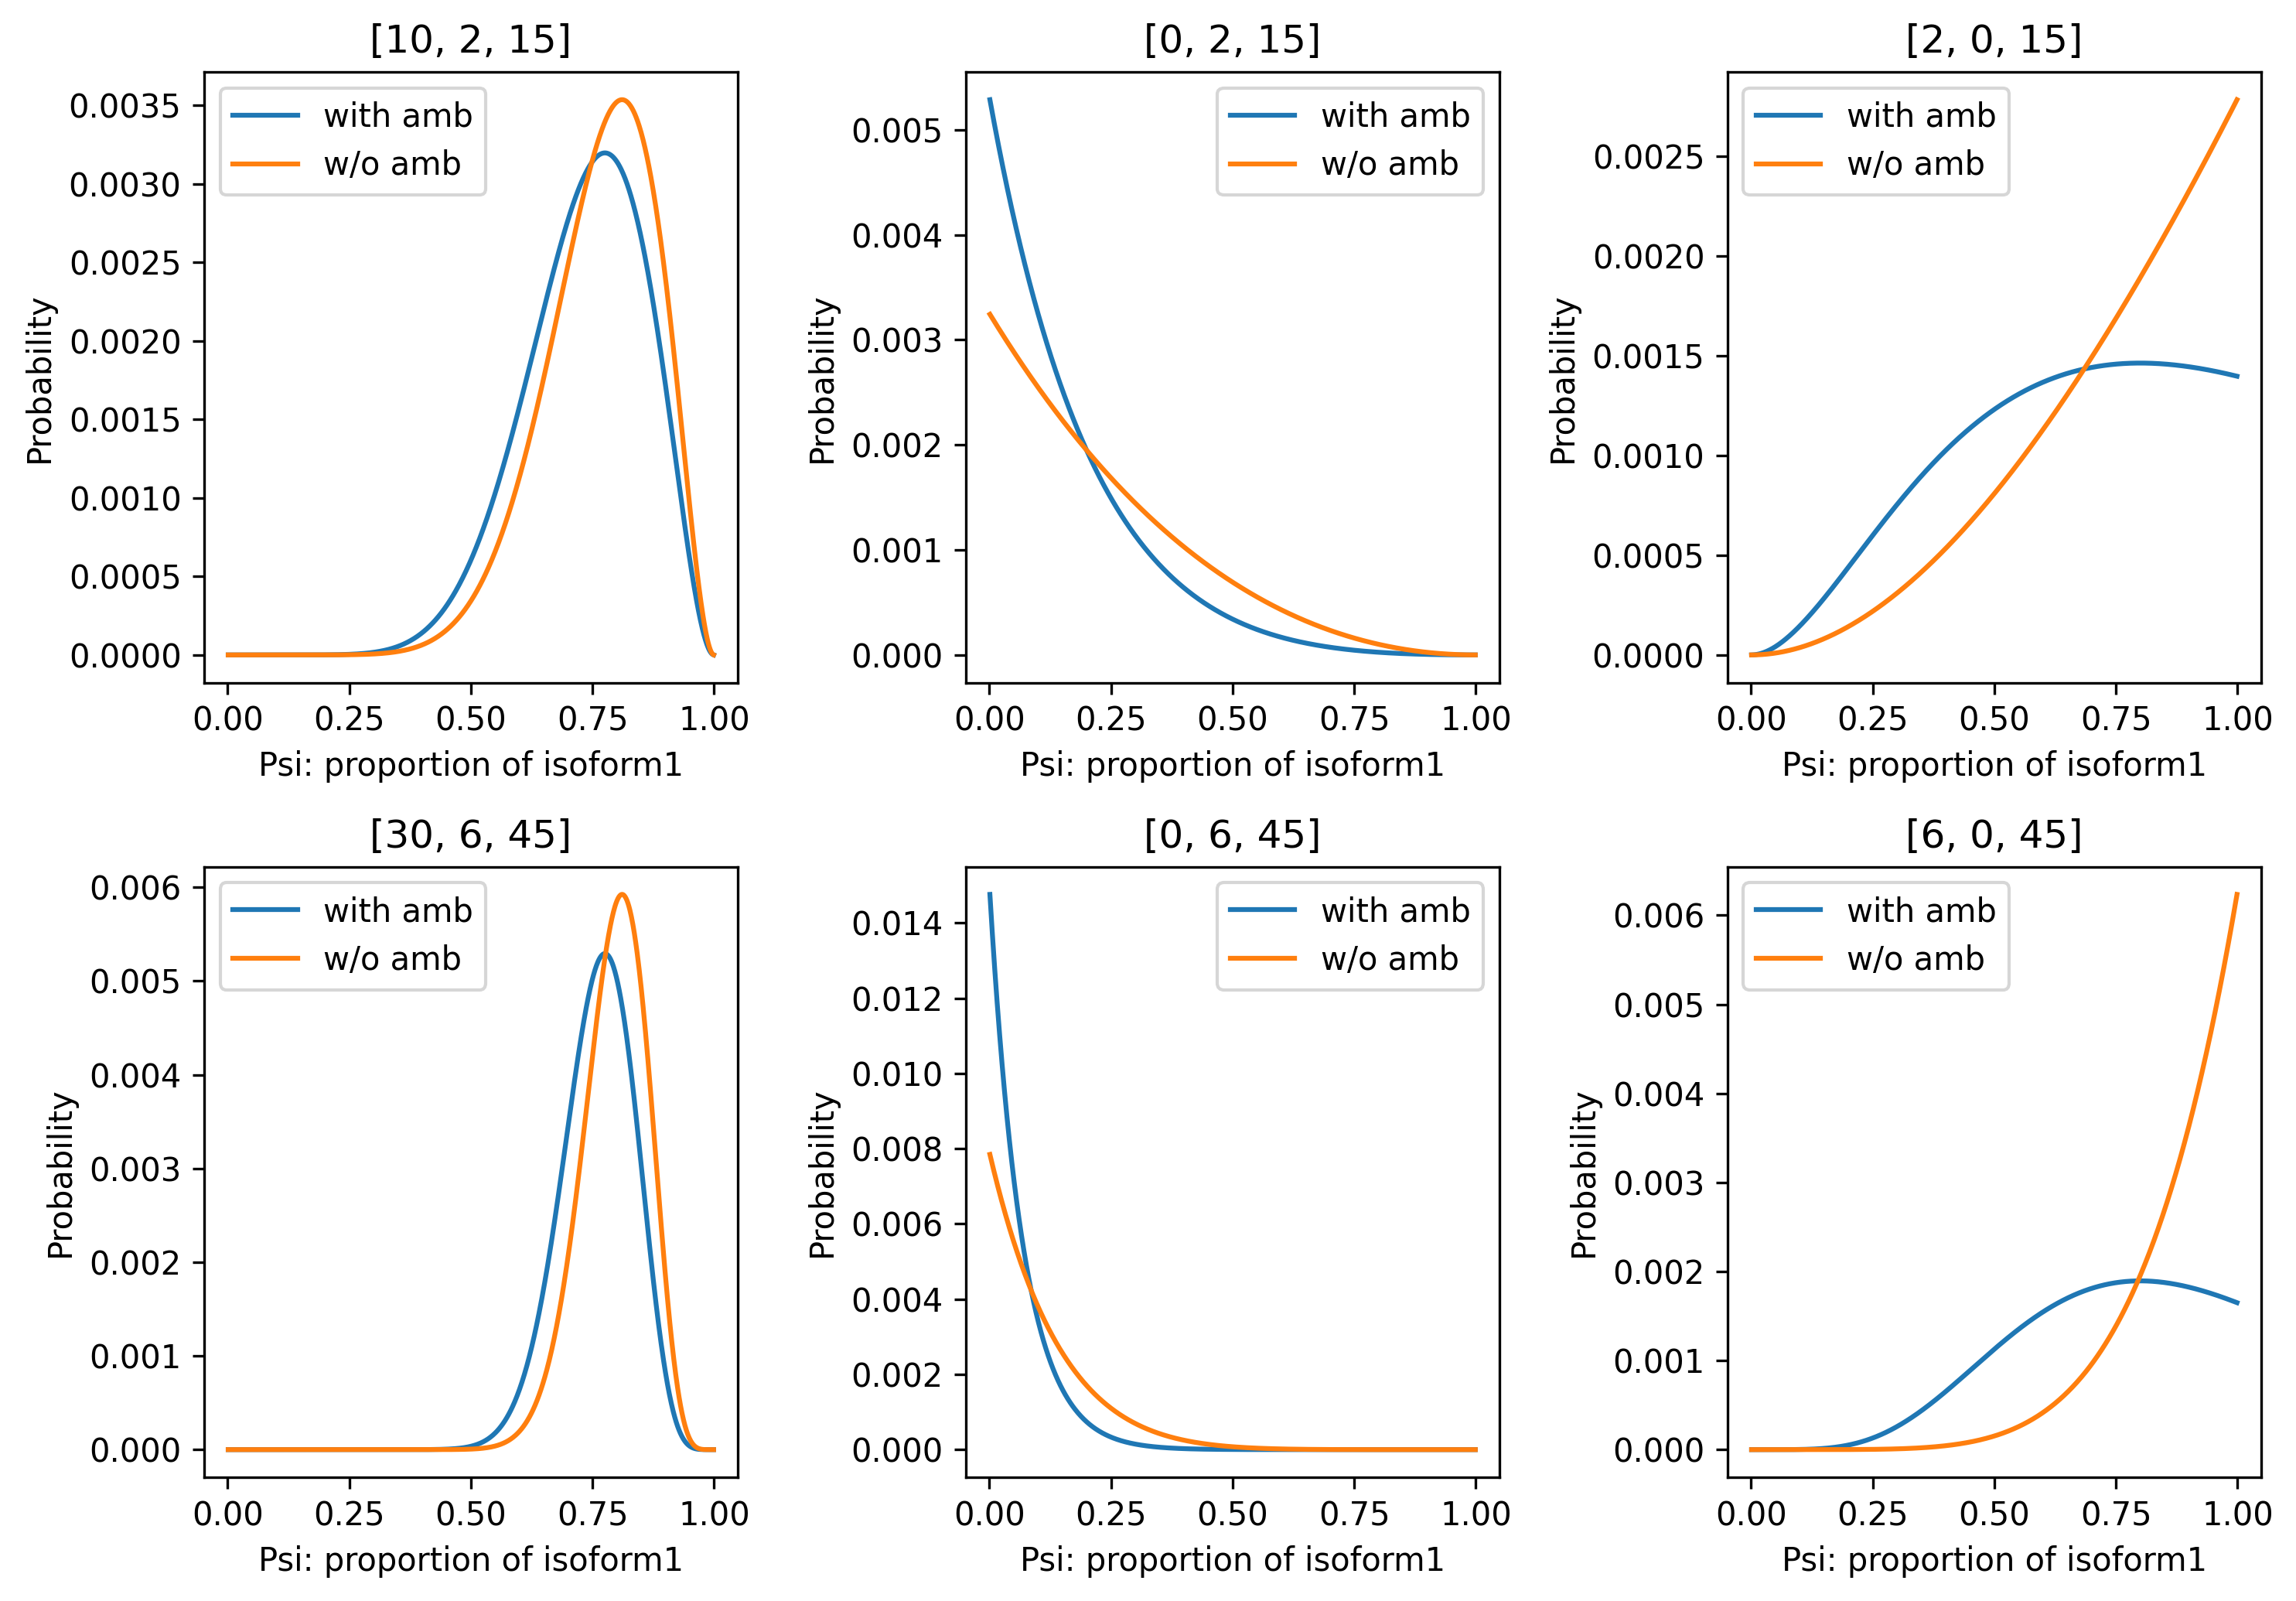

In [2]:
lengths = [200, 100, 500]

count_list = [
    [10, 2, 15],
    [0, 2, 15],
    [2, 0, 15],
    
    [30, 6, 45],
    [0, 6, 45],
    [6, 0, 45],
]

fig = plt.figure(figsize=(10, 7), dpi=300)
for i in range(len(count_list)):
    counts = count_list[i]
    counts_no_amb = counts.copy()
    counts_no_amb[2] = 0

    xx = np.linspace(0, 1, 1001)[1:-1]
    yy = [BRIE_base_lik(x, counts, lengths) for x in xx]
    zz = [BRIE_base_lik(x, counts_no_amb, lengths) for x in xx]
    zz = zz / np.sum(zz)
    if sum(counts_no_amb) == 0:
        zz[:] = 1 / len(zz)
    yy = yy / np.sum(yy)

    plt.subplot(2, len(count_list)/2, i+1)
    plt.plot(xx, yy, label="with amb")
    plt.plot(xx, zz, label="w/o amb")
    plt.title(counts) #['c1', 'c2', 'c3'], '=', 
    plt.xlabel("Psi: proportion of isoform1")
    plt.ylabel("Probability")
    plt.legend(loc='best')
    
plt.tight_layout()
plt.show()